# Investment strategy weight by premium/rebate

In [16]:
import numpy as np
import pandas as pd
import requests
import xlsxwriter
import math
import lxml.html as lh
import lxml.etree as etree
from selenium import webdriver
from requests.utils import quote
import time
import re
import math
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data
from yahoo_fin.stock_info import get_live_price

### Read configuration file

In [5]:
# Read df and set nan to empty string
stocks_df = pd.read_csv('data/ib_stocks_stockholm.csv')
stocks_df.fillna('', inplace=True)

# List of stocks
stocks_list = stocks_df['Ticker'].tolist()

# Get url-ending list
url_ending_list = stocks_df['URL_PATH'].tolist()

# Get element-name list
element_names = stocks_df['ELEMENT_NAME'].tolist()

# Comply with format of yahoo finance for swedish stocks
stocks_df['Ticker'] = stocks_df['Ticker'].str.replace(' ','-')
stocks_df['Ticker'] = stocks_df['Ticker'].astype(str) + '.ST'
stocks_list_yf = stocks_df['Ticker'].tolist()

print(stocks_list_yf)

['BURE.ST', 'AJA-B.ST', 'CRED-A.ST', 'FASTAT.ST', 'FIRST-B.ST', 'FLAT-B.ST', 'HAV-B.ST', 'INDU-C.ST', 'INVE-B.ST', 'KDEV.ST', 'KINV-B.ST', 'LATO-B.ST', 'LINC.ST', 'LUND-B.ST', 'NAXS.ST', 'NAIG-B.ST', 'SVOL-B.ST', 'TRAC-B.ST', 'VEFAB.ST', 'VNV.ST', 'ORES.ST']


### Read current stock price from yahoo financials

In [22]:
current_price = {}
for ticker in stocks_list_yf:
    #historical_datas[ticker] = get_data(ticker, index_as_date = True, interval="1d").tail(1)
    current_price[ticker] = get_live_price(ticker)
historical_datas

{'BURE.ST': 275.79998779296875,
 'AJA-B.ST': 295.0,
 'CRED-A.ST': 94.0,
 'FASTAT.ST': 12.9399995803833,
 'FIRST-B.ST': 3.8299999237060547,
 'FLAT-B.ST': 9.333999633789062,
 'HAV-B.ST': 22.25,
 'INDU-C.ST': 277.3999938964844,
 'INVE-B.ST': 204.14999389648438,
 'KDEV.ST': 1.8650000095367432,
 'KINV-B.ST': 167.35000610351562,
 'LATO-B.ST': 222.3000030517578,
 'LINC.ST': 74.30000305175781,
 'LUND-B.ST': 486.29998779296875,
 'NAXS.ST': 59.70000076293945,
 'NAIG-B.ST': 6.998000144958496,
 'SVOL-B.ST': 68.5,
 'TRAC-B.ST': 232.0,
 'VEFAB.ST': 2.2799999713897705,
 'VNV.ST': 29.579999923706055,
 'ORES.ST': 123.19999694824219}

### Crawl pages to read reported and computed rebate/premium values

In [19]:
driver = webdriver.Firefox()
driver.set_page_load_timeout(10)

base_url='https://ibindex.se/ibi/#/'
html_pages = {}
for index, url_ending in enumerate(url_ending_list):
    driver.get(f'{base_url}{quote(url_ending)}')
    driver.refresh()
    time.sleep(4)
    html = driver.page_source
    html_pages[stocks_list[index]] = html
driver.quit()

### Create data structure for calculated and reported rebate/premiums sorted by stocks

In [20]:
rebate_premium_dict = {}
regexp_number = '(\d{1,2}.\d{1,2})'
regexp_rebate_premium = '(rabatt|premie)'

for index, symbol in enumerate(stocks_list):
    doc = lh.fromstring(html_pages[symbol])
    if(element_names[index] != ''):
        rebate_premium_list = doc.xpath(f'//{element_names[index]}//span')
    else:
        rebate_premium_list = doc.xpath('//app-company-current-rebate-premium//span')
    vals = [el.text for el in rebate_premium_list]
    if(len(vals) == 6):
        val1 = float(re.search(regexp_number, vals[1]).group(1))
        val2 = float(re.search(regexp_number, vals[4]).group(1))
        valtype1 = re.search(regexp_rebate_premium, vals[2]).group(1)
        valtype2 = re.search(regexp_rebate_premium, vals[5]).group(1)
    else:
        val1 = 0
        val2 = 0
        valtype1 = 'premium'
        valtype2 = 'premium'
          
    computed_dict = {
        'val': val1,
        'type': valtype1
    }
    reported_dict = {
        'val': val2,
        'type': valtype2
    }
    rebate_premium_dict[symbol] = {'computed': computed_dict, 'reported': reported_dict}

### Create dataframe

In [31]:
my_columns = ['Ticker', 'Price', 'Reported Val', 'Reported Type', 'Reported Weight','Reported Position', 'Computed Val', 'Computed Type', 'Computed Weight','Computed Position', 'Rep Buy', 'Comp Buy']
final_dataframe = pd.DataFrame(columns = my_columns)

for idx, symbol_yf in enumerate(stocks_list_yf):
    symbol = stocks_list[idx]
    computed_val = rebate_premium_dict[symbol]['computed']['val']
    computed_type = rebate_premium_dict[symbol]['computed']['type']
    reported_val = rebate_premium_dict[symbol]['reported']['val']
    reported_type = rebate_premium_dict[symbol]['reported']['type']
    series_list = [symbol, current_price[symbol_yf], reported_val, reported_type, 'N/A', 'N/A', computed_val, computed_type, 'N/A', 'N/A', 'N/A', 'N/A']
    panda_series = pd.Series(series_list, index = my_columns)
    final_dataframe = final_dataframe.append(panda_series, ignore_index=True)

reported_sum = 0
computed_sum = 0
for index, row in final_dataframe.iterrows():
    if(row['Reported Type'] == 'rabatt'):
        reported_sum += row['Reported Val']
    if(row['Computed Type'] == 'rabatt'):
        computed_sum += row['Computed Val']

final_dataframe['Reported Weight'] = final_dataframe['Reported Val']/reported_sum
final_dataframe.loc[final_dataframe['Reported Type'] == 'premie', 'Reported Weight'] = 0 
final_dataframe['Computed Weight'] = final_dataframe['Computed Val']/computed_sum
final_dataframe.loc[final_dataframe['Computed Type'] == 'premie', 'Computed Weight'] = 0
final_dataframe

/var/folders/xv/b12365j13k53z5vt7sn5rg4m0000gn/T/ipykernel_50427/676646025.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.append(panda_series, ignore_index=True)
/var/folders/xv/b12365j13k53z5vt7sn5rg4m0000gn/T/ipykernel_50427/676646025.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.append(panda_series, ignore_index=True)
/var/folders/xv/b12365j13k53z5vt7sn5rg4m0000gn/T/ipykernel_50427/676646025.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_dataframe = final_dataframe.append(panda_series, ignore_index=True)
/var/folders/xv/b12365j13k53z5vt7sn5rg4m0000gn/T/ipykernel_50427/676646025.py:12: FutureWarning: The frame.append method is dep

,Ticker,Price,Reported Val,Reported Type,Reported Weight,Reported Position,Computed Val,Computed Type,Computed Weight,Computed Position,Rep Buy,Comp Buy
0,BURE,275.799988,40.36,premie,0.000000,N/A,26.22,premie,0.000000,N/A,N/A,N/A
1,AJA B,295.000000,0.00,premium,0.000000,N/A,0.00,premium,0.000000,N/A,N/A,N/A
2,CRED A,94.000000,44.62,premie,0.000000,N/A,39.61,premie,0.000000,N/A,N/A,N/A
3,FASTAT,12.940000,49.75,rabatt,0.225042,N/A,48.65,rabatt,0.203761,N/A,N/A,N/A
4,FIRST B,3.830000,0.00,premium,0.000000,N/A,0.00,premium,0.000000,N/A,N/A,N/A
5,FLAT B,9.334000,0.00,premium,0.000000,N/A,0.00,premium,0.000000,N/A,N/A,N/A
6,HAV B,22.250000,0.00,premium,0.000000,N/A,0.00,premium,0.000000,N/A,N/A,N/A
7,INDU C,277.399994,5.32,rabatt,0.024065,N/A,12.63,rabatt,0.052898,N/A,N/A,N/A
8,INVE B,204.149994,7.20,rabatt,0.032569,N/A,10.20,rabatt,0.042721,N/A,N/A,N/A
9,KDEV,1.865000,59.46,rabatt,0.268965,N/A,59.46,rabatt,0.249037,N/A,N/A,N/A


### Input portfolio size

In [24]:
portfolio_size = input("Enter the value of your portfolio:")

try:
    val = float(portfolio_size)
except ValueError:
    print("That's not a number! \n Try again:")
    portfolio_size = input("Enter the value of your portfolio:")

Enter the value of your portfolio:3000


### Compute position to the different stocks

In [25]:
final_dataframe['Reported Position'] = final_dataframe['Reported Weight']*val
final_dataframe['Computed Position'] = final_dataframe['Computed Weight']*val
final_dataframe

,Ticker,Price,Reported Val,Reported Type,Reported Weight,Reported Position,Computed Val,Computed Type,Computed Weight,Computed Position,Rep Buy,Comp Buy
0,BURE,275.799988,40.36,premie,0.000000,0.000000,26.22,premie,0.000000,0.000000,N/A,N/A
1,AJA B,295.000000,0.00,premium,0.000000,0.000000,0.00,premium,0.000000,0.000000,N/A,N/A
2,CRED A,94.000000,44.62,premie,0.000000,0.000000,39.61,premie,0.000000,0.000000,N/A,N/A
3,FASTAT,12.940000,49.75,rabatt,0.225042,675.125526,48.65,rabatt,0.203761,611.283297,N/A,N/A
4,FIRST B,3.830000,0.00,premium,0.000000,0.000000,0.00,premium,0.000000,0.000000,N/A,N/A
5,FLAT B,9.334000,0.00,premium,0.000000,0.000000,0.00,premium,0.000000,0.000000,N/A,N/A
6,HAV B,22.250000,0.00,premium,0.000000,0.000000,0.00,premium,0.000000,0.000000,N/A,N/A
7,INDU C,277.399994,5.32,rabatt,0.024065,72.194328,12.63,rabatt,0.052898,158.694924,N/A,N/A
8,INVE B,204.149994,7.20,rabatt,0.032569,97.706609,10.20,rabatt,0.042721,128.162171,N/A,N/A
9,KDEV,1.865000,59.46,rabatt,0.268965,806.893744,59.46,rabatt,0.249037,747.110069,N/A,N/A


### Create final dataframe

In [26]:
def styler(df):
    color = 'color: {}'.format
    mask = pd.concat([df['Reported Type'].gt('premium')] * df.shape[1], axis=1)
    style = np.where(mask, color('green'), color('red'))
    return style

# Buy
final_dataframe['Comp Buy'] = final_dataframe['Computed Position']/final_dataframe['Price']
final_dataframe['Comp Buy'] = final_dataframe['Comp Buy'].apply(np.floor)

final_dataframe['Rep Buy'] = final_dataframe['Reported Position']/final_dataframe['Price']
final_dataframe['Rep Buy'] = final_dataframe['Rep Buy'].apply(np.floor)
styled = final_dataframe.style.apply(styler, axis=None)
styled


,Ticker,Price,Reported Val,Reported Type,Reported Weight,Reported Position,Computed Val,Computed Type,Computed Weight,Computed Position,Rep Buy,Comp Buy
0,BURE,275.799988,40.360000,premie,0.000000,0.000000,26.220000,premie,0.000000,0.000000,0.000000,0.000000
1,AJA B,295.000000,0.000000,premium,0.000000,0.000000,0.000000,premium,0.000000,0.000000,0.000000,0.000000
2,CRED A,94.000000,44.620000,premie,0.000000,0.000000,39.610000,premie,0.000000,0.000000,0.000000,0.000000
3,FASTAT,12.940000,49.750000,rabatt,0.225042,675.125526,48.650000,rabatt,0.203761,611.283297,52.000000,47.000000
4,FIRST B,3.830000,0.000000,premium,0.000000,0.000000,0.000000,premium,0.000000,0.000000,0.000000,0.000000
5,FLAT B,9.334000,0.000000,premium,0.000000,0.000000,0.000000,premium,0.000000,0.000000,0.000000,0.000000
6,HAV B,22.250000,0.000000,premium,0.000000,0.000000,0.000000,premium,0.000000,0.000000,0.000000,0.000000
7,INDU C,277.399994,5.320000,rabatt,0.024065,72.194328,12.630000,rabatt,0.052898,158.694924,0.000000,0.000000
8,INVE B,204.149994,7.200000,rabatt,0.032569,97.706609,10.200000,rabatt,0.042721,128.162171,0.000000,0.000000
9,KDEV,1.865000,59.460000,rabatt,0.268965,806.893744,59.460000,rabatt,0.249037,747.110069,432.000000,400.000000


### Plot distribution of stocks to buy - Reported Rebate

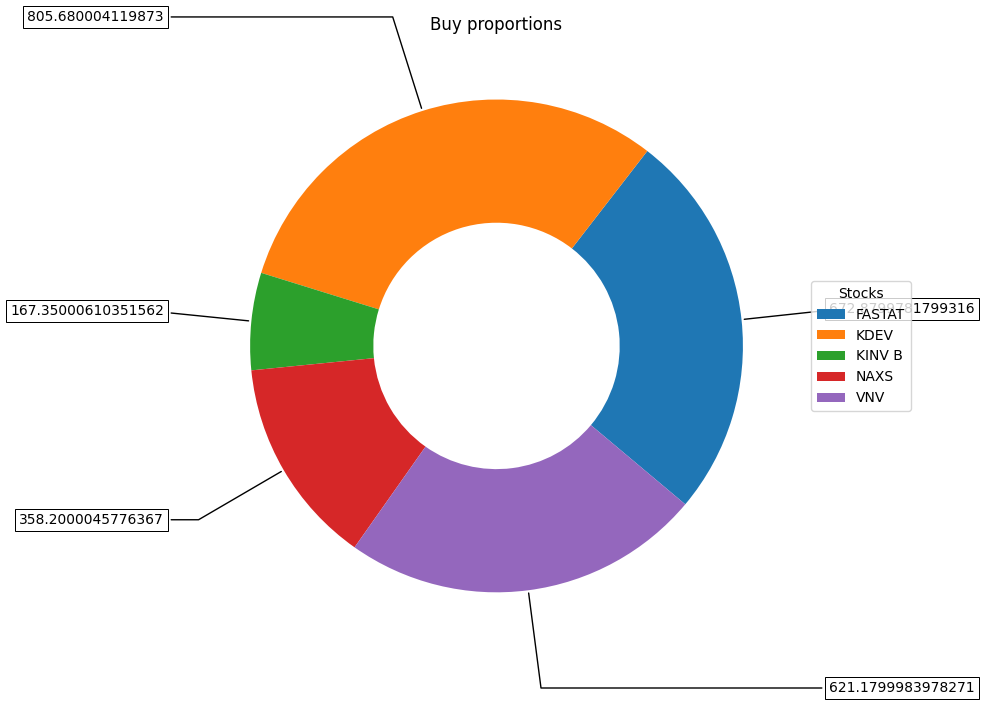

   Budget      Buy Sum  Money left  Total shares to buy  Company count
0  3000.0  2625.289991  374.710009                512.0              5


In [27]:
labels = []
sizes = []
stocks_count = 0
for index, row in final_dataframe.iterrows():
    if(row['Rep Buy'] != 0):
        labels.append(row['Ticker'])
        sizes.append(row['Rep Buy']*row['Price'])
        stocks_count += row['Rep Buy']

fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(aspect="equal"))
#ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(sizes[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.legend(wedges, labels, title="Stocks", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Buy proportions')

plt.show()

data = {'Budget': [val], 'Buy Sum': [sum(sizes)], 'Money left': [val-sum(sizes)], 'Total shares to buy': [stocks_count], 'Company count': [len(sizes)]}
print(pd.DataFrame.from_dict(data))